In [1]:
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

import FinanceDataReader as fdr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
def load_data(code, start_date, end_date):
    if end_date == datetime.today().strftime('%Y-%m-%d'):
        data = fdr.DataReader(code, start_date)
    else:
        data = fdr.DataReader(code, start_date, end_date)
    return data['Close'] # 종가만 남김.

In [3]:
def buy_etf(money, etf_price, last_etf_num, fee_rate, etf_rate):
    etf_num = money * etf_rate // etf_price
    etf_money = etf_num * etf_price
    etf_fee = (last_etf_num - etf_num) * etf_price * fee_rate if last_etf_num > etf_num else 0
    
    while etf_num > 0 and money < (etf_money + etf_fee):
        etf_num -= 1
        etf_money = etf_num * etf_price
        etf_fee = (last_etf_num - etf_num) * etf_price * fee_rate if last_etf_num > etf_num else 0
    purchase_money = etf_money + etf_fee
    
    
    # return money, etf_num, etf_money
    return purchase_money, etf_num, etf_money

In [4]:
def back_test(money: int, fee_rate: float, interval: int, codes: list, etf_rates: list, start_date: str, end_date: str = datetime.today().strftime('%Y-%m-%d')):
    
    start_date = datetime.strptime(start_date, '%Y-%m-%d') # 조회시작일
    
    etfs = []
    for code in codes:
        etfs.append(load_data(code, start_date, end_date))
    
    df = pd.concat(etfs, axis=1, keys=[code for code in codes])
    df = df.fillna(method='ffill')
    
    # print(df.isnull().sum())
    
    # 리밸런싱 날짜의 데이터만 new_df에 남깁니다.
    new_df = pd.DataFrame()
    while start_date <= df.index[-1]:
        temp_date = start_date
        while temp_date not in df.index and temp_date < df.index[-1]:
            temp_date += timedelta(days=1) # 영업일이 아닐 경우 1일씩 증가.
        new_df = new_df.append(df.loc[temp_date])
        start_date += relativedelta(months=interval) # interval 개월씩 증가.
        
    etf_nums = [0 for i in range(len(etfs))]
    etf_prices = [new_df[code][0] for code in codes]
    etf_moneys = [0 for i in range(len(etfs))]
    
    
    backtest_df = pd.DataFrame() # 백테스트를 위한 데이터프레임

    for each in new_df.index:
        for i in range(len(etfs)):
            etf_prices[i] = new_df[codes[i]][each]
        
        # 보유 etf 매도
        for i in range(len(etfs)):
            money += etf_nums[i] * etf_prices[i]
        
        # etf 매입
        init_money = money
        for i in range(len(etfs)):
            buy_money, etf_nums[i], etf_moneys[i] = buy_etf(init_money, etf_prices[i], etf_nums[i], fee_rate, etf_rates[i])
            money -= buy_money
        
        total = money
        for i in range(len(etfs)):
            total += etf_moneys[i]
            
        # backtest_df[each] = []
        backtest_df[each] = [int(total)]
        # backtest_df[each] = [float(total)]
        
    # 행열을 바꿈
    backtest_df = backtest_df.transpose()
    backtest_df.columns = ['backtest', ]
    
    # 백테스트 결과 출력
    # print(backtest_df)
    
    # 최종 데이터 프레임, 3개의 지표와 백테스트 결과
    final_df = pd.concat([new_df, backtest_df], axis=1)
    print(final_df)
    
    profit_df = final_df.pct_change()
    
    profit_acc_df = (1 + profit_df).cumprod() - 1
    
    profit_log_df = np.log(profit_df + 1)
    
    profit_acc_log_df = profit_log_df.cumsum()
    
    final_acc_log_df = profit_acc_log_df * 100
    
    # 그래프 출력
    for i in range(len(etfs)):
        plt.plot(final_acc_log_df[codes[i]].index, final_acc_log_df[codes[i]], label='{}'.format(codes[i]))
    plt.plot(final_acc_log_df['backtest'].index, final_acc_log_df['backtest'], label='Backtest')
    
    plt.legend(loc='upper left')
    plt.show()
    
    # CAGR 계산
    CAGRs = []
    for i in range(len(etfs)):
        delta = final_df.index[-1] - final_df.index[0]
        years = delta.days / 365
        CAGR = (final_df[codes[i]][-1] / final_df[codes[i]][0]) ** (1 / years) - 1
        CAGRs.append(CAGR)
    delta = final_df.index[-1] - final_df.index[0]
    years = delta.days / 365
    CAGR = (final_df['backtest'][-1] / final_df['backtest'][0]) ** (1 / years) - 1
    CAGRs.append(CAGR)
    
    # CAGR 출력
    for i in range(len(etfs)):
        print("{} CAGR: {}".format(codes[i], CAGRs[i] * 100))
    print("Total CAGR: {}".format(CAGRs[-1] * 100))

               KS11    148070  backtest
2015-01-02  1926.44  101790.0  10000000
2016-01-04  1918.76  109207.0  10264910
2017-01-02  2026.16  110533.0  10658404
2018-01-02  2479.65  108984.0  12029541
2019-01-02  2010.00  116388.0  10986537
2020-01-02  2175.17  121020.0  11699448
2021-01-04  2944.45  122580.0  14239275
2022-01-03  2988.77  118885.0  14197572


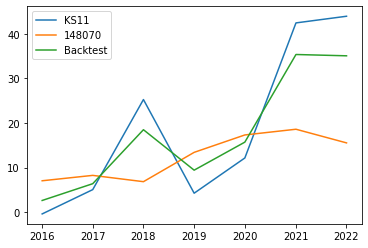

KS11 CAGR: 6.467287027752655
148070 CAGR: 2.2398987772391354
Total CAGR: 5.128233367069113


In [5]:
back_test(10_000_000, 0.002, 12, ['KS11', '148070'], [0.6, 0.4], '2015-01-01')